## Crypto Investment Recommender - Demo Walkthrough

This notebook demonstrates how a simple, **rule-based statistical recommender model** evaluates crypto assets using recent market data.

Instead of using machine learning, it applies **statistical and financial heuristics** to measure:
- Momentum (recent price trends)
- Value (distance from highs/lows, recovery potential)
- Stability (volatility, market cap strength)
- Market position (dominance and liquidity)

The system produces an **investment score** (0–100) and a **recommendation** such as “Strong Buy” or “Hold”, based on explainable financial logic.

In this section, I imported the key components of my workflow, data collection and feature engineering modules.</br>
I’ll use a subset of coins to demonstrate how the rule-based recommender works.

In [8]:
import pandas as pd
from src.feature_engineer import CryptoFeatureEngineer

MARKET_PATH = r"data/raw/crypto_market_data.csv"
HIST_PATH = r"data/raw/crypto_historical_data.csv"
OUTPUT_PATH = r"data/processed/crypto_features.csv"

# Initialize the feature engineer
engineer = CryptoFeatureEngineer(MARKET_PATH, HIST_PATH)


2025-10-23 22:45:19,995 INFO: Loaded market data: 21 rows
2025-10-23 22:45:19,996 INFO: Loaded historical data: 2366 rows


In the cell above, I imported `CryptoFeatureEngineer` class from our script. <br> 
It loads the **market snapshot** and **historical price data** into pandas DataFrames.<br> 

These CSVs come from the CoinGecko API and contain metrics like current price, 24h high/low, and market cap.


In [9]:
engineer.calculate_momentum_features()

2025-10-23 22:46:25,079 INFO: Calculating momentum features


### What This Does
- Calculates **momentum indicators** (1h, 24h, 7d) from available price change columns.
- Combines them into a single `momentum_score` (weighted 30%-30%-40%).
- Adds **volume-to-market-cap ratio** as a liquidity signal.
- Adds **market cap change percentage** for trend strength.

**Why:**  
Momentum captures short-term direction, coins with positive or rising momentum may indicate active investor confidence.

**Alternative Approach:**  
You could compute momentum from historical returns directly (using rolling averages or RSI), but this simpler snapshot-based approach avoids overcomplication for small datasets.

In [10]:
engineer.calculate_value_features()

2025-10-23 22:47:01,303 INFO: Calculating value features


### What This Does
Creates features describing whether a coin is **overvalued or undervalued**:
- `distance_from_ath`: how far the price is from its all-time high.
- `recovery_potential`: combines momentum + distance from ATH to find “rebounding” assets.
- `growth_from_atl`: percent growth since all-time low.
- `price_range_24h`: daily volatility range.
- `scarcity_score`: based on circulating vs total supply.

**Why:**  
This helps spot coins that may be temporarily undervalued or rebounding after a dip.


In [11]:
engineer.calculate_stability_features()

2025-10-23 22:47:25,412 INFO: Calculating stability features
2025-10-23 22:47:25,414 INFO: Calculating historical volatility per coin


### What This Does
Assesses **risk and consistency** of an asset:
- Computes **volatility** from historical prices if available.
- Normalizes **market cap** and **volume** to 0–100 scores.
- Combines them into a single **stability_score**.

**Why:**  
Stable coins (lower volatility, high market cap) are less risky.  
This mirrors institutional portfolio risk metrics.



In [12]:
engineer.calculate_market_position_features()

2025-10-23 22:48:20,864 INFO: Calculating market position features


### What This Does
Measures how strong a coin is relative to others:
- `rank_score`: higher for top-ranked coins by market cap.
- `market_dominance`: coin’s share of total market cap.
- `liquidity_score`: based on trading volume relative to market size.
- `market_tier`: categorizes coins as “Blue Chip,” “Large Cap,” “Mid Cap,” or “Small Cap.”

**Why:**  
Top coins tend to have better liquidity and investor trust, influencing long-term sustainability.


In [13]:
engineer.calculate_composite_investment_score()

2025-10-23 22:48:58,457 INFO: Calculating composite investment score


### What This Does
Combines normalized features into a single **investment_score (0–100)**:
- Momentum (35%)
- Recovery potential (25%)
- Stability (20%)
- Market rank (20%)

**Why:**  
This weighted average produces a balanced, interpretable score that reflects both short-term and long-term appeal.


In [14]:
engineer.classify_risk_levels()
engineer.generate_recommendations()

2025-10-23 22:49:13,238 INFO: Classifying risk levels
2025-10-23 22:49:13,242 INFO: Generating recommendations


### What This Does
- Classifies coins into risk levels (`Conservative`, `Moderate`, `Aggressive`)  
  based on volatility and rank.
- Generates **recommendations**:
  - Strong Buy
  - Buy
  - Moderate Buy
  - Hold
  - Avoid/Sell
- Creates a **reasoning** text that summarizes each asset’s signals.

**Why:**  
These labels make the output easy for non-technical users or investors to understand.


In [16]:
out_df = engineer.save_features(OUTPUT_PATH)
out_df.head()

2025-10-23 22:49:41,758 INFO: Saved features to data/processed/crypto_features.csv (rows=21)


,id,current_price,market_cap,market_cap_rank,momentum_score,recovery_potential,stability_score,rank_score,investment_score,risk_level,recommendation,reasoning,volatility_score,volume_to_mcap_ratio,market_tier,distance_from_ath,liquidity_score,market_dominance
3,binancecoin,1116.26,155347403895,4,1.695099,80.508530,50.255985,94.545455,82.511266,Moderate,Strong Buy,"Positive momentum (+1.7%), market leader.",0.875837,2.986966,Blue Chip,18.46038,24.531696,4.473812
5,solana,189.10,103386811229,6,1.618724,60.485617,54.632082,90.909091,72.058014,Moderate,Buy,"Positive momentum (+1.6%), established player.",0.776916,6.352634,Large Cap,35.56898,52.173632,2.977411
0,bitcoin,109714.00,2187787558021,1,0.743573,70.223072,74.269289,100.000000,70.261433,Conservative,Buy,"Positive momentum (+0.7%), market leader, low ...",0.499803,2.711408,Blue Chip,12.99098,22.268564,63.005558
1,ethereum,3833.06,462958978711,2,0.710805,80.213242,61.062048,98.181818,69.463633,Conservative,Buy,"Positive momentum (+0.7%), market leader, low ...",0.703261,7.283043,Blue Chip,22.43412,59.815006,13.332642
2,tether,1.00,182593125527,3,0.002266,80.000680,95.300080,96.363636,68.788143,Conservative,Buy,"Positive momentum (+0.0%), market leader, low ...",0.006408,58.993155,Blue Chip,24.38332,100.000000,5.258455


### What This Does
Saves the engineered dataset to `data/processed/crypto_features.csv`  
and displays the top 10 coins ranked by `investment_score`.

Each row shows:
- Risk level
- Recommendation
- Reasoning (momentum, liquidity, etc.)


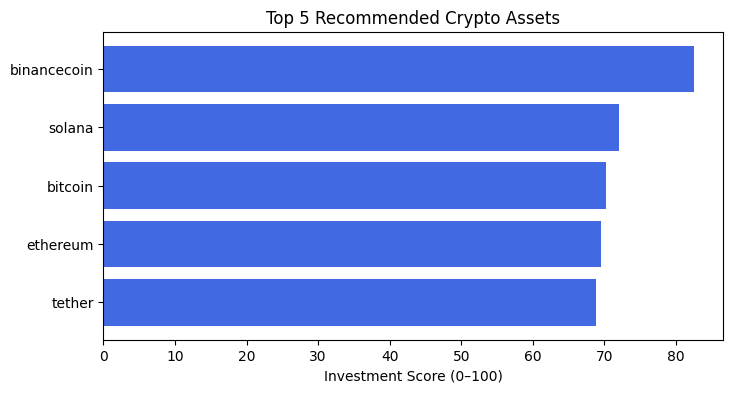

In [17]:
import matplotlib.pyplot as plt

top_coins = out_df.head(5)
plt.figure(figsize=(8,4))
plt.barh(top_coins['id'], top_coins['investment_score'], color='royalblue')
plt.gca().invert_yaxis()
plt.title("Top 5 Recommended Crypto Assets")
plt.xlabel("Investment Score (0–100)")
plt.show()


This bar chart shows the top investment candidates according to the model’s scoring system.


### Summary
This rule-based approach demonstrates how explainable, interpretable metrics
can drive crypto asset ranking without requiring deep learning or complex models.

**Key Strengths:**
- Fully transparent logic
- Easy to explain and justify to stakeholders
- Extendable into an ML-based system later
